# Prediction of Disease in Casava Plants

## Cam for cassava leaf model.

# Load the needed Librarys

In [1]:
#Load Nessicery Librarys
import numpy as np 
import pandas as pd 

import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
# Any results you write to the current direct



#ory are saved as output.

from time import time

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import TensorBoard

import tensorflow as tf
from tensorflow.keras.models import Model

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import math
from PIL import Image

# Cam Creation

This secion we are creating the Cam. What this is going to do is it is going to pull in the model and an image and see where the model activated on the image. These activations are then put into a heatmap which is then overlayed on the actual image to see the parts of the image where the model is picking up information on. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        if self.layerName is None:
            self.layerName = self.find_target_layer()
            
    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if len(layer.output_shape) == 4:
                return layer.name
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
        
    def compute_heatmap(self, image, eps=1e-8):
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,self.model.output]
       )
           
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = castConvOutputs * castGrads * grads
            convOutputs = convOutputs[0]
            guidedGrads = guidedGrads[0]

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            (w, h) = (image.shape[2], image.shape[1])
            heatmap = cv2.resize(cam.numpy(), (w, h))
            numer = heatmap - np.min(heatmap)
            denom = (heatmap.max() - heatmap.min()) + eps
            heatmap = numer / denom
            heatmap = (heatmap * 255).astype("uint8")
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
        colormap = cv2.COLORMAP_VIRIDIS):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

# Load data and images, and create the image generator.

In [2]:
train = pd.read_csv("/content/drive/MyDrive/Prediction of Disease in Cassava Plants. /Cassava/train.csv",dtype=str)
train_path = "/content/drive/MyDrive/Prediction of Disease in Cassava Plants. /Cassava/train_images"
bs = 256
Val_datagen = ImageDataGenerator(rescale=1/255)
valid_generator = Val_datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = "image_id",
    y_col = "label",
    batch_size = bs,
    #seed = 1,
    shuffle = True,
    class_mode = "categorical",
    target_size = (150,200))

Found 21397 validated image filenames belonging to 5 classes.


# Generate Predictions on the training images

## This will be used in the CAM.

This section is going to create the predictions on the training data. The cam will take this information. Once you have created the predictions you will put the prediciton of the image you want to see in the cam in the Ture_false_id



In [3]:
cnn = keras.models.load_model('/content/drive/MyDrive/Prediction of Disease in Cassava Plants. /my_model_retrain_v01.h5')
test_pred = cnn.predict(valid_generator)

test_fnames = valid_generator.filenames
pred_classes = np.argmax(test_pred, axis=1)

KeyboardInterrupt: ignored

In [ ]:
test_pred

test_fnames = valid_generator.filenames
pred_classes = np.argmax(test_pred, axis=1)

submission = pd.DataFrame({
    'image_id':test_fnames,
    'label':pred_classes
})

submission

# Generate the heat map over the selected image. 

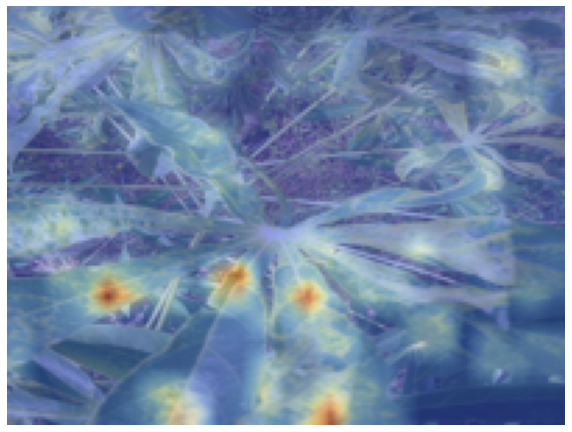

In [ ]:
ture_False_id = 3

img = Image.open("/content/drive/MyDrive/Kaggle Projects/Cassava/train_images/999329392.jpg")                            # Load image file
img = img.resize((200,150))                                # Resize image to fit CNN dimensions
img_array = np.array(img).reshape(1,150,200,3) / 255       # Convert image to array
cam = GradCAM(cnn, ture_False_id)                # Create an instance of the CAM class
heatmap = cam.compute_heatmap(img_array)                   # Create a heatmap to overlay on the image
plt.figure(figsize=(10,10))                                # Display the image with an overlay. 
plt.imshow(img_array[0,:,:, :], alpha=1.0)
plt.imshow(heatmap, alpha=0.6, cmap='coolwarm')
plt.axis('off')
plt.show()